### Imports

In [1]:
! pip install emoji
! pip install pyarabic
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! git clone https://github.com/rfahrn/Shared_Task.git

fatal: destination path 'Shared_Task' already exists and is not an empty directory.


In [3]:
import random
import time
import numpy as np
import pandas as pd
import emoji
import unicodedata
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pyarabic.araby as ar
import pickle
import string

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [5]:
train = pd.read_csv('Shared_Task/data/offenseval-ar-training-v1.tsv', sep='\t', encoding='utf-8')

### Preview data

In [6]:
train.head(10)

,id,tweet,subtask_a
0,1,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT
1,2,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT
2,3,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF
3,4,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT
4,5,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT
5,6,@USER اخخ يا قلببي يا هالحلقه 😩😭♥️ متعه على بك...,NOT
6,7,والله الزول السوداني أثبت أنه سابق بالتحضّر عن...,NOT
7,8,"RT @USER: جالس أسمع أحمد قاسم يغني: ""أحبك من ك...",NOT
8,9,في قلبي يا مغلاك<LF>وبعيني يا محلاك ..,NOT
9,10,يا التاج ع الراس يا السادة<LF>يا مالك الروح ور...,NOT


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count NOT/OFF')

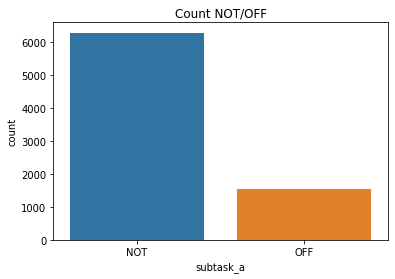

In [7]:
sns.countplot(train.subtask_a)
plt.title('Count NOT/OFF')

We can see that there are much more non-offensive than offensive tweets - a common issue in HSD data. Transformers tend to perform better with balanced datasets.

# Text Preprocessing

### Jessica

In [8]:
# PUNCTUATION = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''


# def remove_emoji(tweet):
#     return emoji.get_emoji_regexp().sub(u'', tweet)


# def remove_lf(tweet):
#     """ This string appears in many tweets and appears to serve no linguistic function. """
#     return tweet.replace('<LF>', ' ')


# def remove_repeat_chars(tweet):
#     """ Removes only non-digit, non-punctuation characters that are repeated more than once, since double characters can appear in correct spelling. """
#     new = ''

#     for char in tweet:
#         if char.isdigit():
#             new += char
#         elif char in PUNCTUATION:
#             new += char
#         else:
#             if not new.endswith(char+char):
#                 new += char

#     return new


# def remove_diacritics(tweet):
#     """ Diacritics in Arabic serve no semantic or syntactic function. """
#     tweet = ar.strip_tashkeel(tweet)
#     tweet = ar.strip_tatweel(tweet)

#     tweet = tweet.replace("آ", "ا")
#     tweet = tweet.replace("إ", "ا")
#     tweet = tweet.replace("أ", "ا")
#     tweet = tweet.replace("ؤ", "و")
#     tweet = tweet.replace("ئ", "ي")

#     return tweet


# def normalise_encoding(tweet):
#     tweet = re.sub(r'&amp;', '&', tweet)
#     tweet = unicodedata.normalize('NFC', tweet)
#     return tweet


# train['tweet'] = train['tweet'].apply(remove_lf)
# train['tweet'] = train['tweet'].apply(remove_repeat_chars)
# train['tweet'] = train['tweet'].apply(remove_diacritics)
# train['tweet'] = train['tweet'].apply(normalise_encoding)
# # Convert to binary values
# train['subtask_a'] = train['subtask_a'].apply(lambda x: 1 if x=='NOT' else 0)

# # Make one df with emoji and one without to compare performance later
# train_no_emoji = train
# train_no_emoji['tweet'] = train_no_emoji['tweet'].apply(remove_emoji)

# dfs = [train, train_no_emoji]

# train.head(10)

### Rebecka

In [9]:
# # Preprocessing Arabic Tweets
# punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

# arabic_diacritics = re.compile("""
#                              ّ    | # Shadda
#                              َ    | # Fatha
#                              ً    | # Tanwin Fath
#                              ُ    | # Damma
#                              ٌ    | # Tanwin Damm
#                              ِ    | # Kasra
#                              ٍ    | # Tanwin Kasr
#                              ْ    | # Sukun
#                              ـ     # Tatwil/Kashida
#                          """, re.VERBOSE)


# def preprocess(text):
#     #remove punctuations
#     translator = str.maketrans('', '', punctuations)
#     text = text.translate(translator)
#     # Normalize unicode encoding
#     text = unicodedata.normalize('NFC',text)

#     # Remove '@name'
#     text = re.sub(r'(@.*?)[\s]', '', text)

#     # Replace '&amp;' with '&'
#     text = re.sub(r'&amp;', '&', text)

#     # Remove trailing whitespace
#     text = re.sub(r'\s+', '', text).strip()
    
#     #Remove URLs
#     text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)

#     # remove Tashkeel
#     text = re.sub(arabic_diacritics, '', text)
    
#     #remove longation
#     text = re.sub("[إأآا]", "ا", text)
#     text = re.sub("ى", "ي", text)
#     text = re.sub("ؤ", "ء", text)
#     text = re.sub("ئ", "ء", text)
#     text = re.sub("ة", "ه", text)
#     text = re.sub("گ", "ك", text)

#     text = ' '.join(word for word in text.split())

#     return text
  
# #train['tweet'] = train['tweet'].apply(preprocess)

# # convert off 1 and not 0
# train['subtask_a']=train['subtask_a'].apply(lambda x: 1 if x=='NOT' else 0)

# train.head(10)

### Main

In [10]:
PUNCTUATION = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''


def remove_emoji(tweet):
  return emoji.get_emoji_regexp().sub(u' ', tweet)


def remove_lf(tweet):
  """ This string appears in many tweets and appears to serve no linguistic function. """
  return tweet.replace('<LF>', ' ')
  

def remove_repeat_chars(tweet):
  """ Removes only non-digit, non-punctuation characters that are repeated more than once, since double characters can appear in correct spelling. """
  new = ''

  for char in tweet:
      if char.isdigit():
          new += char
      elif char in PUNCTUATION:
          new += char
      else:
          if not new.endswith(char+char):
              new += char

  return new


def normalise_encoding(tweet):
  tweet = re.sub(r'&amp;', '&', tweet)
  # tweet = unicodedata.normalize('NFC', tweet)
  tweet = re.sub(r'\\u....', ' ', tweet)  # Remove the \uXXXX that ends up replacing left-to-right space characters
  tweet = re.sub(r'\\xa0', ' ', tweet)  # Remove the \xa0 that ends up replacing NBSP characters
  return tweet


def remove_diacritics(tweet):
  """ Diacritics in Arabic only aid pronunciation, and serve no semantic or syntactic function. """
  tweet = ar.strip_tashkeel(tweet)
  tweet = ar.strip_tatweel(tweet)

  tweet = tweet.replace("آ", "ا")
  tweet = tweet.replace("إ", "ا")
  tweet = tweet.replace("أ", "ا")
  tweet = tweet.replace("ؤ", "و")
  tweet = tweet.replace("ئ", "ي")

  return tweet


train['tweet'] = train['tweet'].apply(normalise_encoding)
train['tweet'] = train['tweet'].apply(remove_lf)
train['tweet'] = train['tweet'].apply(remove_diacritics)
train['tweet'] = train['tweet'].apply(remove_repeat_chars)

# Convert to binary values
train['subtask_a'] = train['subtask_a'].apply(lambda x: 1 if x=='NOT' else 0)

# Make one df with emoji and one without to compare performance later
train_no_emoji = train
train_no_emoji['tweet'] = train_no_emoji['tweet'].apply(remove_emoji)

dfs = [train, train_no_emoji]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  """


In [11]:
train_no_emoji.head(10)

,id,tweet,subtask_a
0,1,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,1
1,2,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,1
2,3,RT @USER: يا رب يا واحد يا احد بحق يوم الاحد ا...,0
3,4,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,1
4,5,يا بكون بحياتك الاهم يا اما ما بدي اكون,1
5,6,@USER اخخ يا قلببي يا هالحلقه متعه على بكا...,1
6,7,والله الزول السوداني اثبت انه سابق بالتحضر عن ...,1
7,8,"RT @USER: جالس اسمع احمد قاسم يغني: ""احبك من ك...",1
8,9,في قلبي يا مغلاك وبعيني يا محلاك ..,1
9,10,يا التاج ع الراس يا السادة يا مالك الروح وراعيها,1


In [12]:
train_no_emoji.head(10)

,id,tweet,subtask_a
0,1,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,1
1,2,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,1
2,3,RT @USER: يا رب يا واحد يا احد بحق يوم الاحد ا...,0
3,4,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,1
4,5,يا بكون بحياتك الاهم يا اما ما بدي اكون,1
5,6,@USER اخخ يا قلببي يا هالحلقه متعه على بكا...,1
6,7,والله الزول السوداني اثبت انه سابق بالتحضر عن ...,1
7,8,"RT @USER: جالس اسمع احمد قاسم يغني: ""احبك من ك...",1
8,9,في قلبي يا مغلاك وبعيني يا محلاك ..,1
9,10,يا التاج ع الراس يا السادة يا مالك الروح وراعيها,1


### Sanity check

In [13]:
def count_chars(tweet):
    return len(tweet)


for df in dfs:
    df['char_count'] = df['tweet'].apply(count_chars)

train_no_emoji.sort_values(by='char_count', ascending=[0]).head(10)

,id,tweet,subtask_a,char_count
2922,2946,من المظاهر الموسفه ان الاب والام يقعدون يتها...,1,5627
6062,6160,جده الحب ،، جده يا منتهى كل الكلام يا سيدة كل...,1,5251
4761,4833,"يا مالي عمري رضا يا شبيه الورد , يا معنى الحي...",1,3097
6564,6707,يا من اظهر الجميل.. وستر القبيح.. يا من لا يوا...,1,2190
2753,2760,يا مكعب السكر يا زمردي الاحمر و ياسري الاكبر ...,1,2079
2124,2125,اللهم اني اسالك مسالة البايس الفقير وادعوك دع...,0,1069
2434,2441,يا سيادة الرييس يا سيادة الرييس نعلم ان الحرب ...,0,284
1399,1400,يا مرحبا ترحيبة عقاب يا نوت والحي يلحق لو تحده...,1,284
1880,1881,يا راجل يا حمار هو عمك السيسي محتاج عياله يعمل...,0,283
3050,3122,انت وامثالك وحكامك وعلمايك الزنادقه خنازير دمر...,0,283


Something is weird with these 6 tweets that have 1000+ characters. Those with 281-284 might be explained by my replacing '\<LF\>' with a space to keep word boundaries intact, but 1000+ is clearly some kind of data reading error. I'll just remove them.

In [14]:
for df in dfs:
    df.drop(df[df['char_count'] > 1000].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

train.sort_values(by='char_count', ascending=[0]).head(10)

,id,tweet,subtask_a,char_count
2433,2441,يا سيادة الرييس يا سيادة الرييس نعلم ان الحرب ...,0,284
1399,1400,يا مرحبا ترحيبة عقاب يا نوت والحي يلحق لو تحده...,1,284
7190,7358,يا عيباه يا حسافاه اليمني بيهان بكل مكان وهذا ...,1,283
3047,3122,انت وامثالك وحكامك وعلمايك الزنادقه خنازير دمر...,0,283
1880,1881,يا راجل يا حمار هو عمك السيسي محتاج عياله يعمل...,0,283
6359,6507,بذلة عسكرية وسط الزحام .. حياة مليية بالاشواك ...,1,282
3019,3094,الله ياخذك يا جاهل يا تعبان يا مريض يا معتوه و...,0,282
475,476,الرساله فيها عشم مش طبيعي بس مش مشكلتي. اولا ك...,0,282
7612,7780,القيناوية غاليين عليا اشرفها مية مية يا خلق يا...,1,282
2653,2661,الهلال امانة في يديكم حنا عند الله ثم عندكم قب...,1,282


# BERT Preprocessing

In [15]:
MAX_LEN = 284

def preprocessing_for_bert(data, version="mini"):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

    # For every sentence...
    for i, sent in enumerate(data):
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            padding='max_length',           # Pad sentence to max length
            return_attention_mask=True,     # Return attention mask
            truncation = True
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

## Train-test split

In [16]:
def tt_split(df):
    items, labels = df['tweet'], df['subtask_a']
    train_items, test_items, train_labels, test_labels = train_test_split(items, labels, test_size=.15, random_state=42)

    train_items = train_items.tolist()
    train_labels = train_labels.to_numpy()
    test_items = test_items.tolist()
    test_labels = test_labels.to_numpy()

    return train_items, train_labels, test_items, test_labels


data_with_emoji = {}
data_without_emoji = {}

data_with_emoji['train items'], data_with_emoji['train labels'], data_with_emoji['test items'], data_with_emoji['test labels'] \
    = tt_split(train)
data_without_emoji['train items'], data_without_emoji['train labels'], data_without_emoji['test items'], data_without_emoji['test labels'] \
    = tt_split(train_no_emoji)

In [17]:
dicts = [data_with_emoji, data_without_emoji]

# Run function `preprocessing_for_bert` on the train and test sets and convert label types to torch.Tensor
for d in dicts:
    d['train input ids'], d['train masks'] = preprocessing_for_bert(d['train items'])
    d['test input ids'], d['test masks'] = preprocessing_for_bert(d['test items'])

    d['train labels'] = torch.tensor(d['train labels'])
    d['test labels'] = torch.tensor(d['test labels'])

# Training

In [18]:
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32
batch_size = 16

## Create the DataLoader for our training set
# With emoji:
train_data_emoji = TensorDataset(data_with_emoji['train input ids'], data_with_emoji['train masks'], data_with_emoji['train labels'])
train_sampler_emoji = RandomSampler(train_data_emoji)
train_dataloader_emoji = DataLoader(train_data_emoji, sampler=train_sampler_emoji, batch_size=batch_size)
# Without emoji:
train_data_no_emoji = TensorDataset(data_without_emoji['train input ids'], data_without_emoji['train masks'], data_without_emoji['train labels'])
train_sampler_no_emoji = RandomSampler(train_data_no_emoji)
train_dataloader_no_emoji = DataLoader(train_data_no_emoji, sampler=train_sampler_no_emoji, batch_size=batch_size)

## Create the DataLoader for our test set
# With emoji:
test_data_emoji = TensorDataset(data_with_emoji['test input ids'], data_with_emoji['test masks'], data_with_emoji['test labels'])
test_sampler_emoji = RandomSampler(test_data_emoji)
test_dataloader_emoji = DataLoader(test_data_emoji, sampler=test_sampler_emoji, batch_size=batch_size)
# Without emoji:
test_data_no_emoji = TensorDataset(data_without_emoji['test input ids'], data_without_emoji['test masks'], data_without_emoji['test labels'])
test_sampler_no_emoji = RandomSampler(test_data_no_emoji)
test_dataloader_no_emoji = DataLoader(test_data_no_emoji, sampler=test_sampler_no_emoji, batch_size=batch_size)

In [19]:
# Create the BertClassifier class
class BertClassifier(nn.Module):
    """ BERT Model for classification tasks. """

    def __init__(self, freeze_bert=False, version="mini"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 256 if version == "mini" else 768
        H, D_out = 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoModel.from_pretrained("asafaya/bert-base-arabic")
        # Instantiate a single-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that holds attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [20]:
def initialize_model(train_dataloader, epochs=4, version="mini"):
    """ Initialize the Bert Classifier, the optimizer and the learning rate scheduler. """

    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

    return bert_classifier, optimizer, scheduler


# Specify loss function
loss_fn = nn.CrossEntropyLoss()


def set_seed(seed_value=42):
    """ Set seed for reproducibility. """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [21]:
def train(model, train_dataloader, test_dataloader=None, epochs=4, evaluation=False):
    """ Train the BertClassifier model. """

    # Start training loop
    print("Starting training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation:
            # After the completion of each training epoch, measure the model's performance on our test set.
            val_loss, val_accuracy = evaluate(model, test_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)

        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """ After the completion of each training epoch, measure the model's performance on our test set. """

    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our test set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the test set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


set_seed(42)
# With emoji:
bert_classifier_emoji, optimizer, scheduler = initialize_model(train_dataloader_emoji, epochs=2)
# Without emoji:
bert_classifier_no_emoji, optimizer, scheduler = initialize_model(train_dataloader_no_emoji, epochs=2)

Some weights of the model checkpoint at asafaya/bert-mini-arabic were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use 

In [22]:
print('WITH EMOJI:')
train(bert_classifier_emoji, train_dataloader_emoji, test_dataloader_emoji, epochs=2, evaluation=True)

WITH EMOJI:
Starting training...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.624902   |     -      |     -     |   1.04   
   1    |   40    |   0.628832   |     -      |     -     |   0.89   
   1    |   60    |   0.634824   |     -      |     -     |   0.89   
   1    |   80    |   0.613833   |     -      |     -     |   0.89   
   1    |   100   |   0.631339   |     -      |     -     |   0.90   
   1    |   120   |   0.631944   |     -      |     -     |   0.89   
   1    |   140   |   0.619359   |     -      |     -     |   0.89   
   1    |   160   |   0.593919   |     -      |     -     |   0.89   
   1    |   180   |   0.616639   |     -      |     -     |   0.90   
   1    |   200   |   0.614539   |     -      |     -     |   0.90   
   1    |   220   |   0.625242   |     -      |     -     |   0.90   
   1    |   240   |   0.614975   |     -      |     -  

In [23]:
print('WITHOUT EMOJI:')
train(bert_classifier_no_emoji, train_dataloader_no_emoji, test_dataloader_no_emoji, epochs=2, evaluation=True)

WITHOUT EMOJI:
Starting training...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.656147   |     -      |     -     |   1.06   
   1    |   40    |   0.647950   |     -      |     -     |   1.01   
   1    |   60    |   0.674811   |     -      |     -     |   1.02   
   1    |   80    |   0.661466   |     -      |     -     |   1.01   
   1    |   100   |   0.658689   |     -      |     -     |   1.01   
   1    |   120   |   0.645983   |     -      |     -     |   1.02   
   1    |   140   |   0.637788   |     -      |     -     |   1.01   
   1    |   160   |   0.630856   |     -      |     -     |   1.02   
   1    |   180   |   0.640175   |     -      |     -     |   1.02   
   1    |   200   |   0.666280   |     -      |     -     |   1.02   
   1    |   220   |   0.652334   |     -      |     -     |   1.02   
   1    |   240   |   0.658542   |     -      |     

In [25]:
# Saving the model for future runs
pickle.dump(bert_classifier_emoji, open('trained_model_mini_with_emoji.sav', 'wb'))
pickle.dump(bert_classifier_no_emoji, open('trained_model_mini_without_emoji.sav', 'wb'))

# Testing

In [26]:
def bert_predict(model, test_dataloader):
    """ Perform a forward pass on the trained BERT model to predict probabilities on the test set. """

    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Evaluating

In [27]:
def calculate_prec_acc(probs, y_true):
    preds = probs[:, 1]

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)

    print(f'Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%')
    print(f'Precision: {precision_score(y_true, y_pred) * 100:.2f}%')
    print(f'Recall: {recall_score(y_true, y_pred) * 100:.2f}%')
    print(f'f1-score: {f1_score(y_true, y_pred) * 100:.2f}%')


# Compute predicted probabilities on the test set
probs_emoji = bert_predict(bert_classifier_emoji, test_dataloader_emoji)
probs_no_emoji = bert_predict(bert_classifier_no_emoji, test_dataloader_no_emoji)

In [28]:
print('--WITH EMOJI--\n')
calculate_prec_acc(probs_emoji, data_with_emoji['test labels'])

--WITH EMOJI--

Accuracy: 78.72%
Precision: 80.14%
Recall: 97.66%
f1-score: 88.04%


In [29]:
print('--WITHOUT EMOJI--\n')
calculate_prec_acc(probs_no_emoji, data_without_emoji['test labels'])

--WITHOUT EMOJI--

Accuracy: 69.02%
Precision: 80.10%
Recall: 81.63%
f1-score: 80.86%
